# LOADING NEEDED PACKAGES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import seaborn as sns
import pmdarima as pm
from prophet import Prophet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
from pandas.api.types import CategoricalDtype
color_pal = sns.color_palette()
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
import warnings 
warnings.filterwarnings('ignore')


# LOADING AND VIEWING DATA

In [27]:
# Loading the dataset using def fuction
def gb_carbon():
    # read the CSV file, identifying indext column using 'index_col' and parse the dates
    data = pd.read_csv('gb_carbon_intensity.csv', parse_dates=True)
    data.set_index('datetime', inplace=True)
    return data

CO2 =gb_carbon()
print(CO2.head()) 

                     forecast  actual index
datetime                                   
2018-01-01T00:00:00     154.0   157.0   low
2018-01-01T00:30:00     159.0   164.0   low
2018-01-01T01:00:00     169.0   171.0   low
2018-01-01T01:30:00     170.0   172.0   low
2018-01-01T02:00:00     165.0   172.0   low


In [3]:
print(CO2.tail()) #checking the last five data

                     forecast  actual index
datetime                                   
2024-08-04T00:00:00       NaN     NaN   NaN
2024-08-04T00:30:00       NaN     NaN   NaN
2024-08-04T01:00:00       NaN     NaN   NaN
2024-08-04T01:30:00       NaN     NaN   NaN
2024-08-04T02:00:00       NaN     NaN   NaN


In [4]:
print(CO2.info()) #Checking the information of each columns

<class 'pandas.core.frame.DataFrame'>
Index: 115541 entries, 2018-01-01T00:00:00 to 2024-08-04T02:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   forecast  112683 non-null  float64
 1   actual    111851 non-null  float64
 2   index     112683 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.5+ MB
None


# DATA CLEANING

In [28]:
# The datetime shows a timespam of 30minutes interval and I will split it in like manner before cleaning 
# '30min', hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season'

# Categorical type for weekdays
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

def create_timespam(CO2):
    # Check if 'datetime' is already the index
    if CO2.index.name == 'datetime':
        CO2.index = pd.to_datetime(CO2.index)
                                   
    # Feature extraction from the datetime
    CO2['30mi'] = CO2.index.floor('30T').time
    CO2['30min'] = CO2['30mi'].apply(lambda x: x.hour * 60 + x.minute + x.second / 60)
    CO2.drop(columns=['30mi'], inplace=True)
    CO2['hour'] = CO2.index.hour
    CO2['dayofweek'] = CO2.index.dayofweek
    CO2['weekday'] = CO2.index.day_name()
    CO2['weekday'] = CO2['weekday'].astype(cat_type)
    CO2['quarter'] = CO2.index.quarter
    CO2['month'] = CO2.index.month
    CO2['year'] = CO2.index.year
    CO2['dayofyear'] = CO2.index.dayofyear
    CO2['dayofmonth'] = CO2.index.day
    CO2['weekofyear'] = CO2.index.isocalendar().week

    # Date offset and season calculation
    CO2['date_offset'] = (CO2.index.month * 100 + CO2.index.day - 320) % 1300
    CO2['season'] = pd.cut(CO2['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])

    return CO2

# Apply the function to the actual DataFrame
CO2 = create_timespam(CO2)
print(CO2.head())


                     forecast  actual index  30min  hour  dayofweek weekday  \
datetime                                                                      
2018-01-01 00:00:00     154.0   157.0   low    0.0     0          0  Monday   
2018-01-01 00:30:00     159.0   164.0   low   30.0     0          0  Monday   
2018-01-01 01:00:00     169.0   171.0   low   60.0     1          0  Monday   
2018-01-01 01:30:00     170.0   172.0   low   90.0     1          0  Monday   
2018-01-01 02:00:00     165.0   172.0   low  120.0     2          0  Monday   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
datetime                                                                       
2018-01-01 00:00:00        1      1  2018          1           1           1   
2018-01-01 00:30:00        1      1  2018          1           1           1   
2018-01-01 01:00:00        1      1  2018          1           1           1   
2018-01-01 01:30:00        1      1  2018     

In [6]:
CO2.info() # to confirm the datatypes

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115541 entries, 2018-01-01 00:00:00 to 2024-08-04 02:00:00
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   forecast     112683 non-null  float64 
 1   actual       111851 non-null  float64 
 2   index        112683 non-null  object  
 3   30min        115541 non-null  float64 
 4   hour         115541 non-null  int64   
 5   dayofweek    115541 non-null  int64   
 6   weekday      115541 non-null  category
 7   quarter      115541 non-null  int64   
 8   month        115541 non-null  int64   
 9   year         115541 non-null  int64   
 10  dayofyear    115541 non-null  int64   
 11  dayofmonth   115541 non-null  int64   
 12  weekofyear   115541 non-null  UInt32  
 13  date_offset  115541 non-null  int64   
 14  season       115205 non-null  category
dtypes: UInt32(1), category(2), float64(3), int64(8), object(1)
memory usage: 12.2+ MB


In [7]:
#I will drop the forecast and index column. they are not needed
CO2.drop(columns=['forecast', 'index'], inplace=True) 
CO2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115541 entries, 2018-01-01 00:00:00 to 2024-08-04 02:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   actual       111851 non-null  float64 
 1   30min        115541 non-null  float64 
 2   hour         115541 non-null  int64   
 3   dayofweek    115541 non-null  int64   
 4   weekday      115541 non-null  category
 5   quarter      115541 non-null  int64   
 6   month        115541 non-null  int64   
 7   year         115541 non-null  int64   
 8   dayofyear    115541 non-null  int64   
 9   dayofmonth   115541 non-null  int64   
 10  weekofyear   115541 non-null  UInt32  
 11  date_offset  115541 non-null  int64   
 12  season       115205 non-null  category
dtypes: UInt32(1), category(2), float64(2), int64(8)
memory usage: 10.5 MB


In [8]:
# To check for empty rows starting from the last few rows 
CO2.tail()

,actual,30min,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
datetime,,,,,,,,,,,,,
2024-08-04 00:00:00,NaN,0.0,0,6,Sunday,3,8,2024,217,4,31,484,Summer
2024-08-04 00:30:00,NaN,30.0,0,6,Sunday,3,8,2024,217,4,31,484,Summer
2024-08-04 01:00:00,NaN,60.0,1,6,Sunday,3,8,2024,217,4,31,484,Summer
2024-08-04 01:30:00,NaN,90.0,1,6,Sunday,3,8,2024,217,4,31,484,Summer
2024-08-04 02:00:00,NaN,120.0,2,6,Sunday,3,8,2024,217,4,31,484,Summer


In [9]:
#Seeing that some rows has 'NaN' I will remove the empyt/'NaN' rows 
#These NaNs rows was created and maybe had not yet been retrived data or was missing when the data was downloaded from the website
CO2.dropna(inplace=True)
has_nan = CO2.isnull().values.any()
print(f"Does the dataset have NaN values? {has_nan}") # to reconfirm if there is still any 'NaNs'

Does the dataset have NaN values? False


# PERFORM PECIFIC ATA ANALYSIS (SDA)

### I will perform visualization to see into the minutes, hour, and so on with the different seasons being part of them

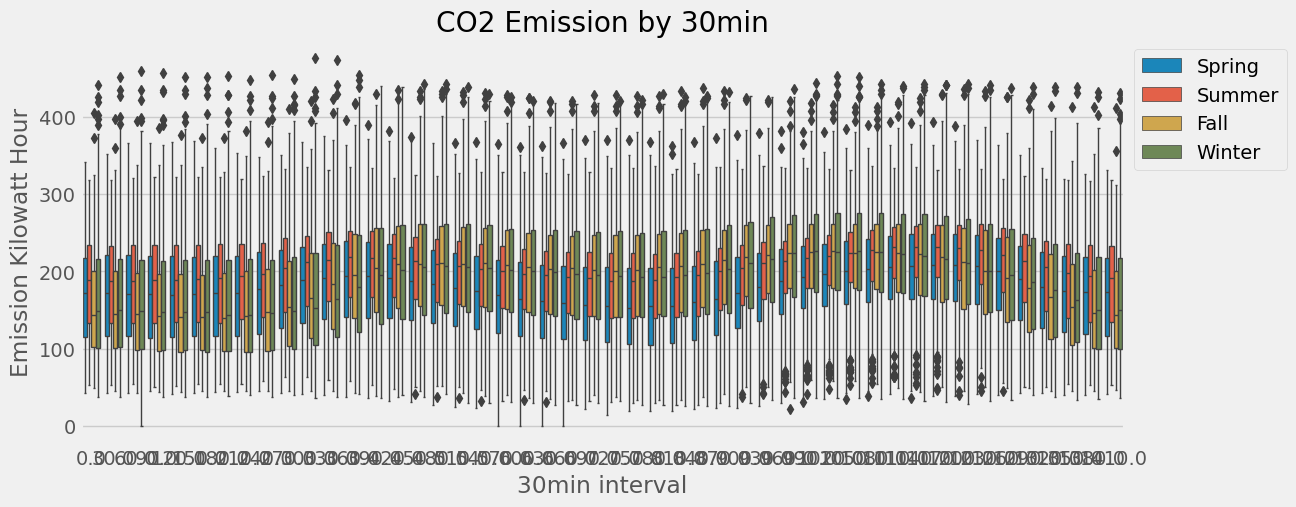

In [10]:
#CO2 emission by 30min with seasons
# Size of the plot
fig, ax = plt.subplots(figsize=(12, 5))

# Plotting the boxplot
sns.boxplot(x='30min',y='actual',hue='season',data=CO2,ax=ax,linewidth=1)

#title and labels
ax.set_title('CO2 Emission by 30min')
ax.set_xlabel('30min interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))

plt.show()


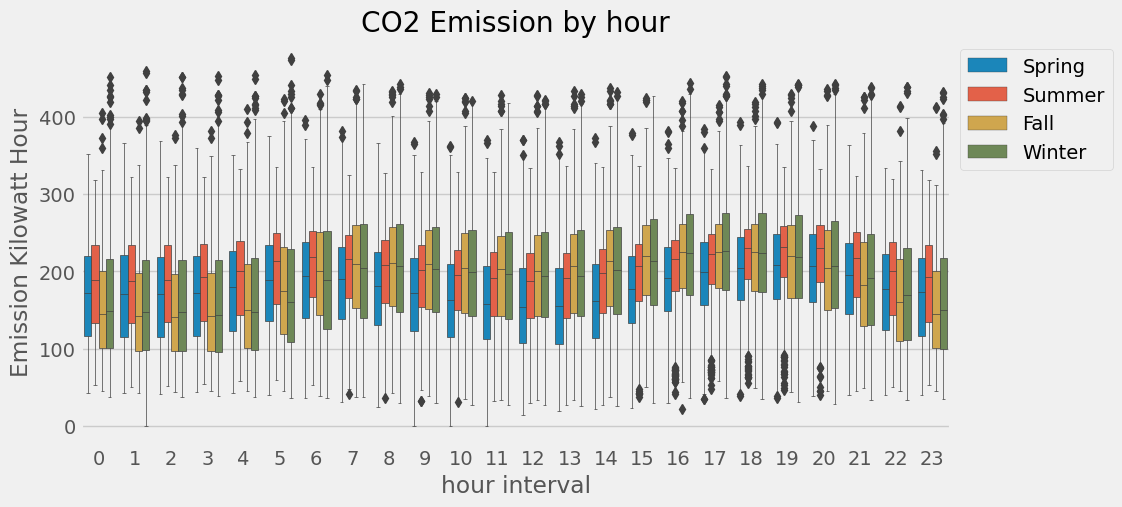

In [11]:
#CO2 emission by an hour with hour with seasons
# Size of the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the boxplot
sns.boxplot(x='hour',y='actual',hue='season',data=CO2,ax=ax,linewidth=.5)

#title and labels
ax.set_title('CO2 Emission by hour')
ax.set_xlabel('hour interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))


plt.show()


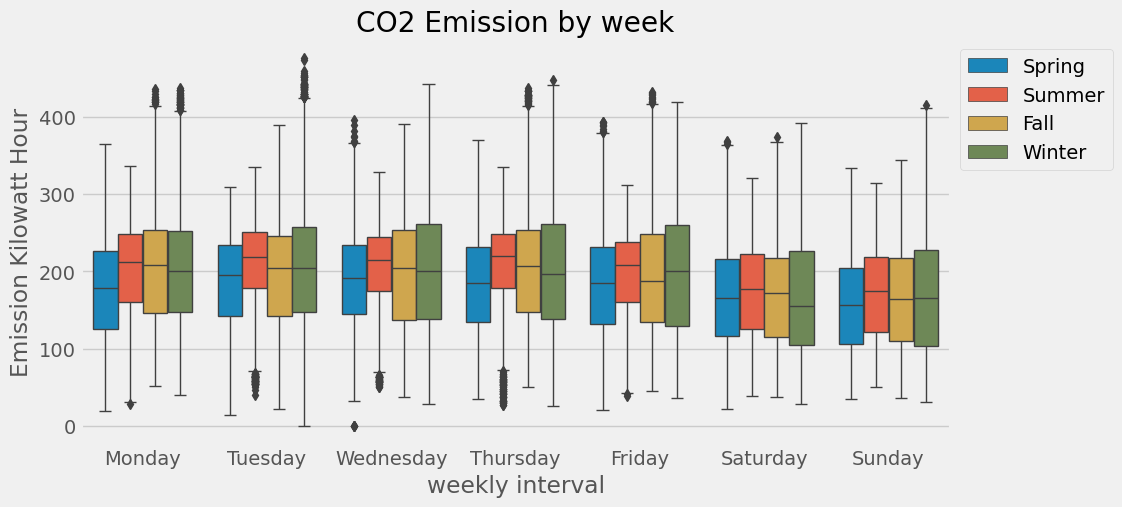

In [12]:
#CO2 emission by weekly with seasons
# Size of the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the boxplot
sns.boxplot(x='weekday', y='actual',hue='season',data=CO2,ax=ax,linewidth=1)

#title and labels
ax.set_title('CO2 Emission by week')
ax.set_xlabel('weekly interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))


plt.show()


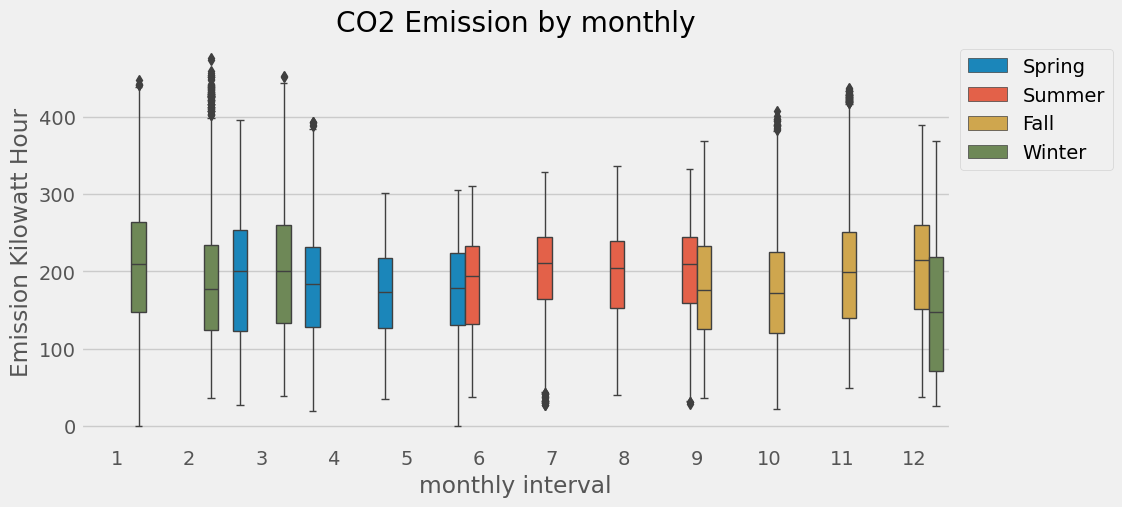

In [13]:
#CO2 emission by monthly with season
# Size of the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the boxplot
sns.boxplot(x='month', y='actual', hue='season', data=CO2, ax=ax,linewidth=1)

#title and labels
ax.set_title('CO2 Emission by monthly')
ax.set_xlabel('monthly interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))


plt.show()


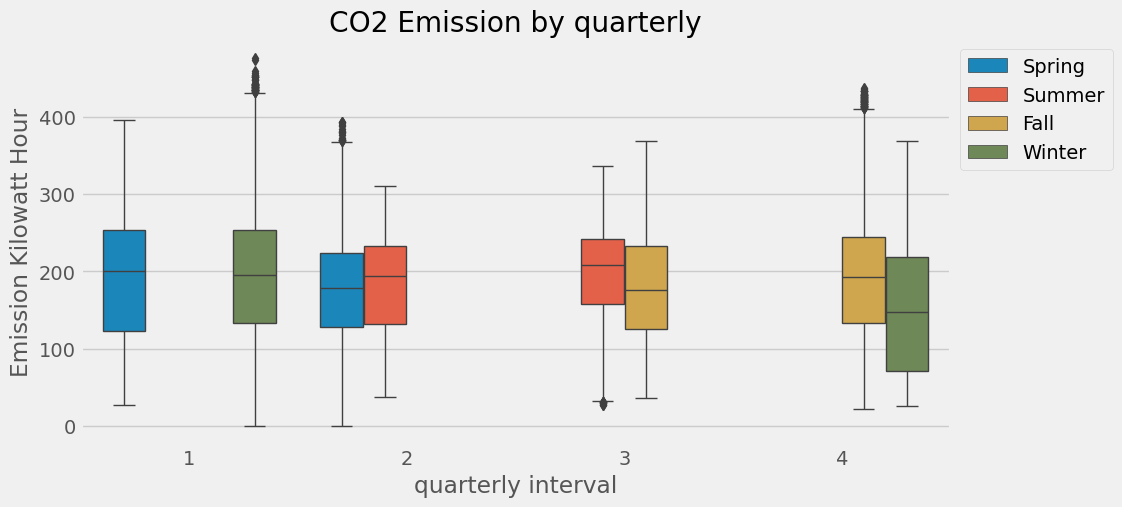

In [14]:
#CO2 emission by quarterly with seasons
# Size of the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the boxplot
sns.boxplot(x='quarter', y='actual', hue='season', data=CO2, ax=ax,linewidth=1)

#title and labels
ax.set_title('CO2 Emission by quarterly')
ax.set_xlabel('quarterly interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))

plt.show()


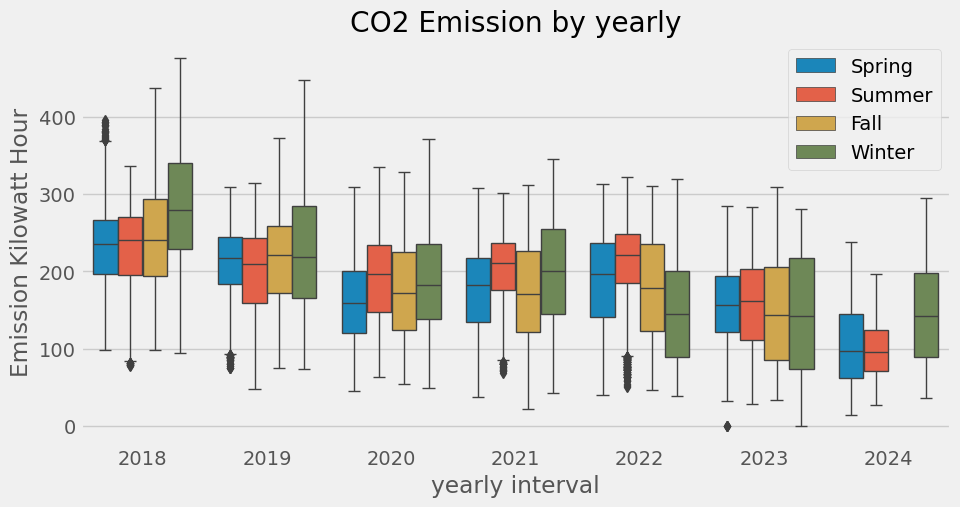

In [15]:
#CO2 emission by yearly with season
# Size of the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the boxplot
sns.boxplot(x='year', y='actual', hue='season', data=CO2, ax=ax,linewidth=1)

#title and labels
ax.set_title('CO2 Emission by yearly')
ax.set_xlabel('yearly interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))


plt.show()


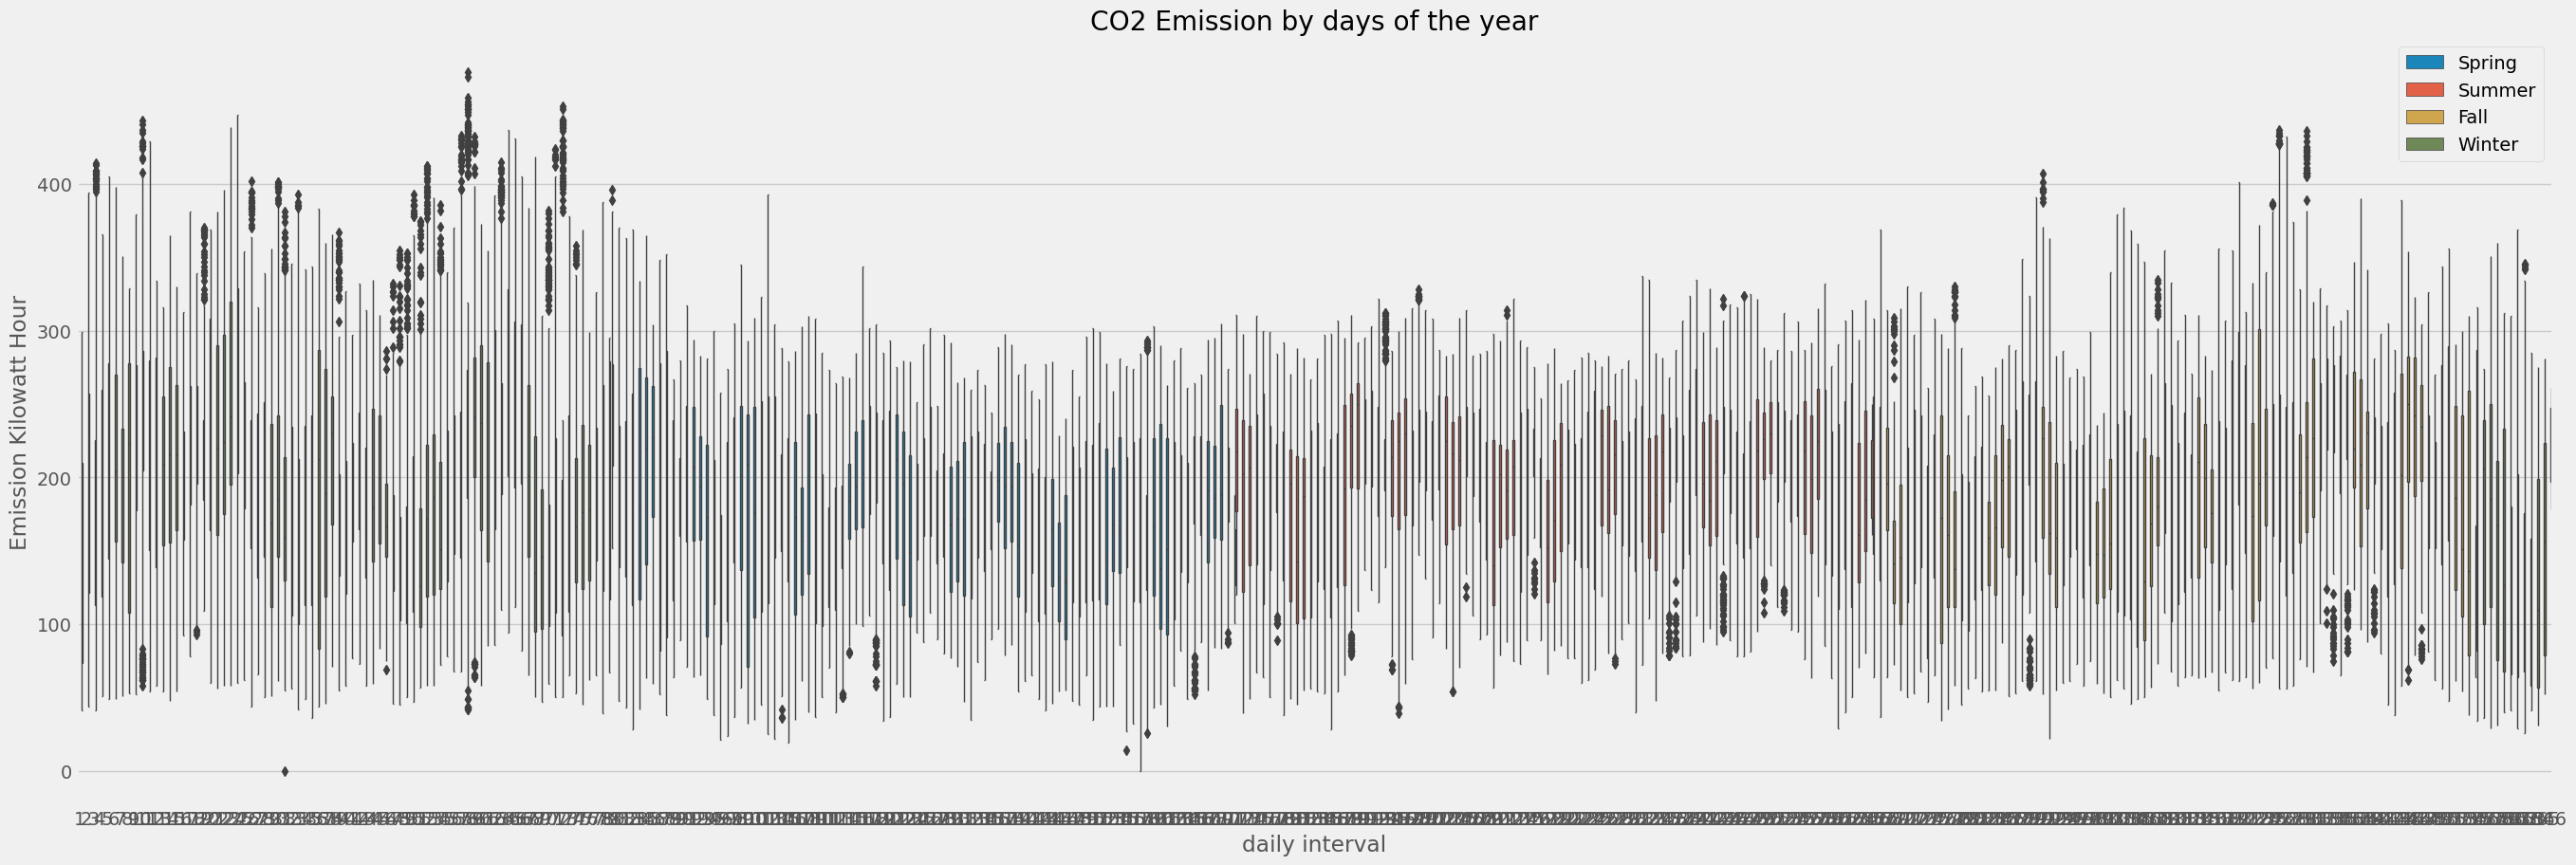

In [16]:
#CO2 emission by 30min
# Size of the plot
fig, ax = plt.subplots(figsize=(30, 10))

# Plotting the boxplot
sns.boxplot(x='dayofyear', y='actual', hue='season', data=CO2, ax=ax,linewidth=1)

#title and labels
ax.set_title('CO2 Emission by days of the year')
ax.set_xlabel('daily interval')
ax.set_ylabel('Emission Kilowatt Hour')
ax.legend(bbox_to_anchor=(1, 1))


plt.show() 


# TO DETERMINE IF THE DATA IS STATIONARY OR NOT
#### In my previous code using XGBoost and ARIMA, l have already comfirmed that the data is stationary. I will just visualize here

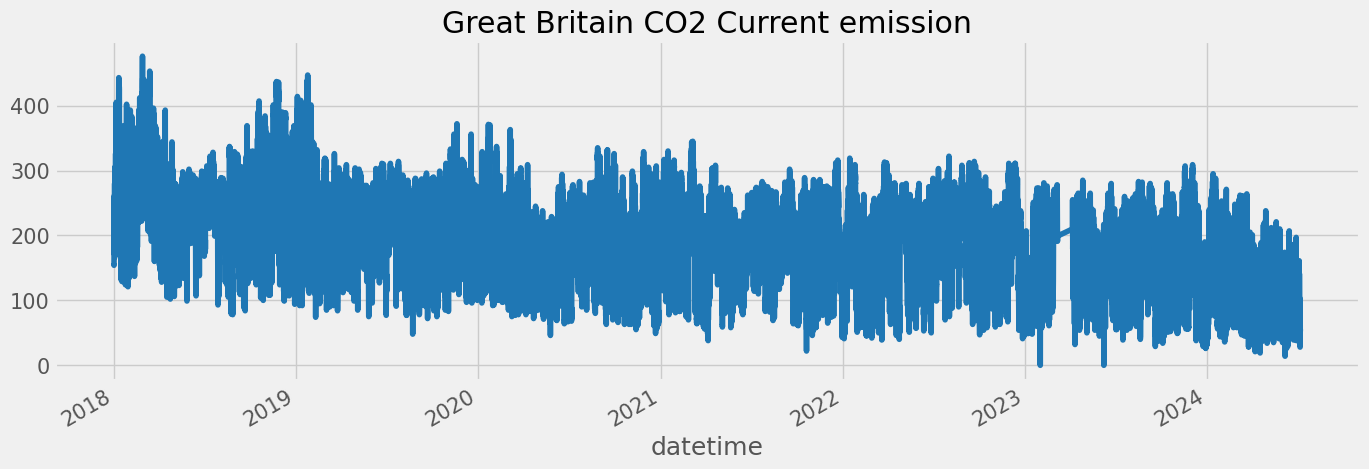

In [17]:
#visualization of 'actual' column 

plt.rcParams['font.size'] = 15
CO2['actual'].plot(figsize=(15,5), color=color_pal[0], title = 'Great Britain CO2 Current emission');
plt.show()

# CREATING TIME SERIES MODELS

### SPLIT THE DATA INTO TRAIN AND TEST 

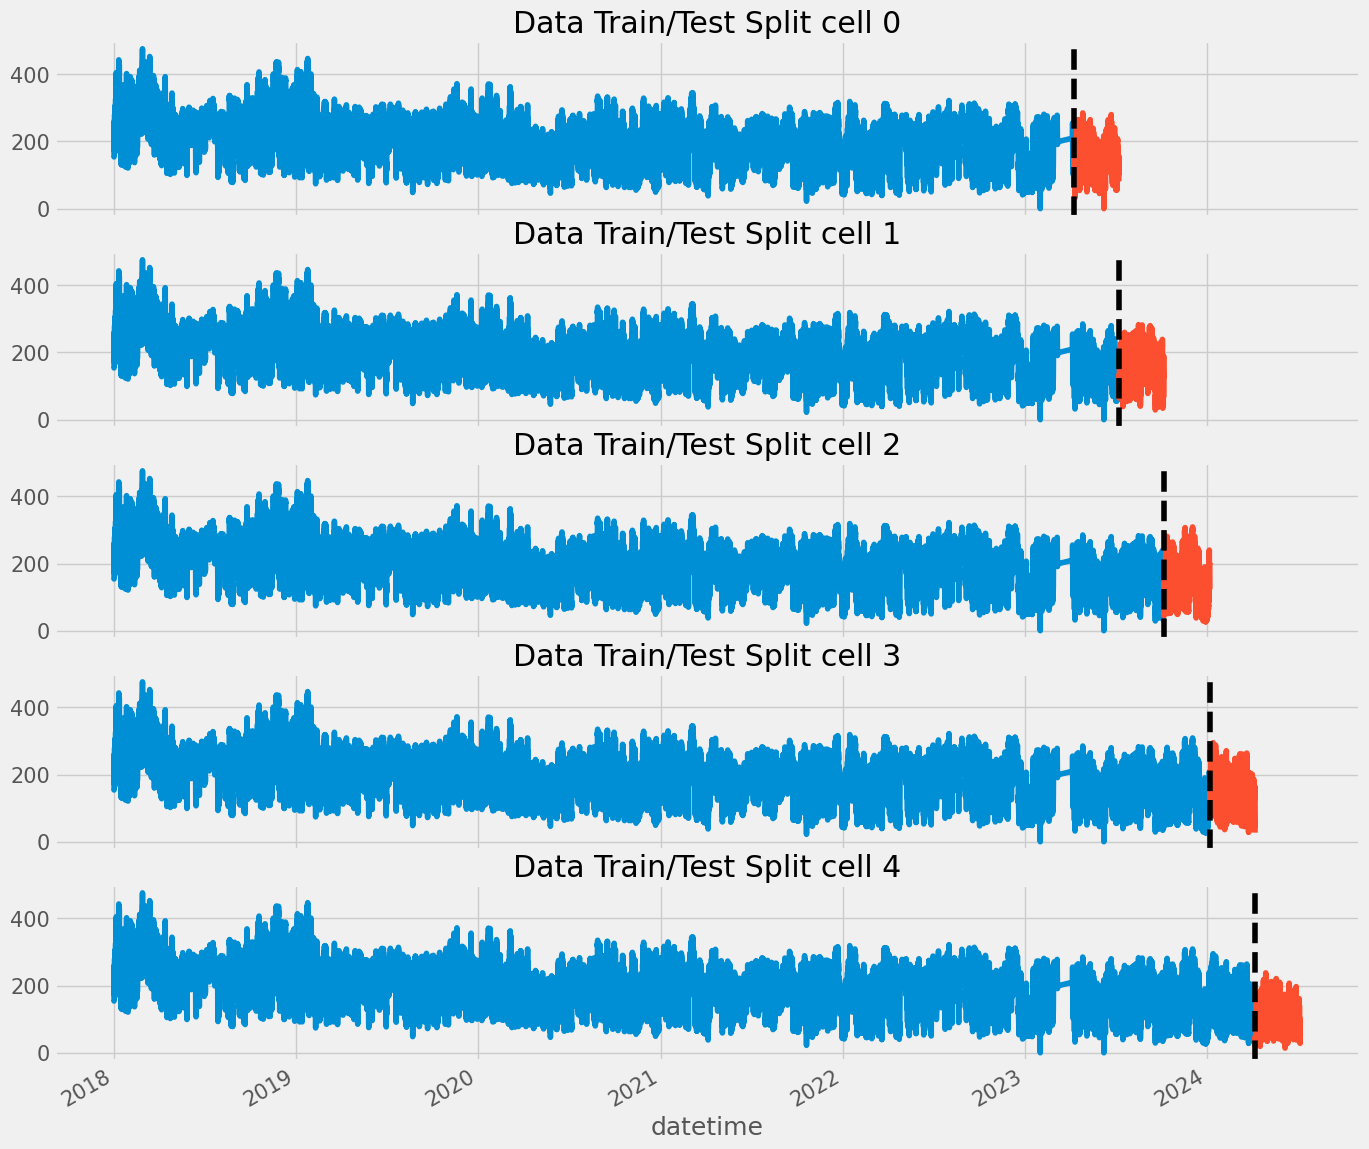

In [18]:
#TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=4320, gap=48)
CO2 = CO2.sort_index()

for train_idex, vali_idex in tss.split(CO2):
    break 

# Visualizing my TimeSeriesSplit
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

cell = 0
splits = []
for train_index, test_index in tss.split(CO2):
    train = CO2.iloc[train_index]
    test = CO2.iloc[test_index]
    splits.append((train, test)) 
    
    train['actual'].plot(ax=axs[cell], label='Training Set', title=f'Data Train/Test Split cell {cell}')
    test['actual'].plot(ax=axs[cell], label='Test Set')
    axs[cell].axvline(test.index.min(), color='black', ls='--')
    cell += 1

plt.show()


In [19]:
#  Prepare the data for Prophet to train using the ds and y as column names 
CO2_prophet_train  = train.reset_index().rename(columns={'datetime': 'ds', 'actual': 'y'})

# train the the model
model = Prophet()
model.fit(CO2_prophet_train)

09:32:31 - cmdstanpy - INFO - Chain [1] start processing
09:35:15 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Predict using test 
CO2_prophet_test = test.reset_index().rename(columns={'datetime': 'ds', 'actual': 'y'})

CO2_test_forecast = model.predict(CO2_prophet_test)

# print(CO2_prophet_test)
CO2_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-04-05 09:30:00,133.742753,57.301431,196.287172,133.742753,133.742753,-2.592380,-2.592380,-2.592380,2.255008,...,4.646899,4.646899,4.646899,-9.494287,-9.494287,-9.494287,0.0,0.0,0.0,131.150373
1,2024-04-05 10:00:00,133.741213,57.167902,195.679768,133.741213,133.741213,-6.459097,-6.459097,-6.459097,-1.298354,...,4.327886,4.327886,4.327886,-9.488629,-9.488629,-9.488629,0.0,0.0,0.0,127.282116
2,2024-04-05 10:30:00,133.739674,50.441390,189.259927,133.739674,133.739674,-9.769649,-9.769649,-9.769649,-4.286086,...,3.999425,3.999425,3.999425,-9.482988,-9.482988,-9.482988,0.0,0.0,0.0,123.970026
3,2024-04-05 11:00:00,133.738135,46.130336,188.014859,133.738135,133.738135,-12.150863,-12.150863,-12.150863,-6.334989,...,3.661489,3.661489,3.661489,-9.477364,-9.477364,-9.477364,0.0,0.0,0.0,121.587272
4,2024-04-05 11:30:00,133.736596,50.770055,188.594137,133.736596,133.736596,-13.428214,-13.428214,-13.428214,-7.270523,...,3.314065,3.314065,3.314065,-9.471756,-9.471756,-9.471756,0.0,0.0,0.0,120.308382


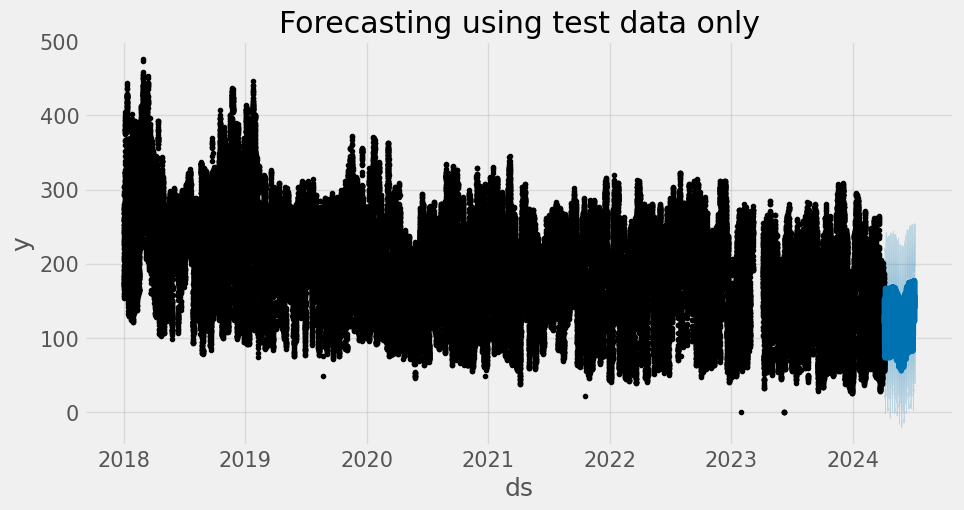

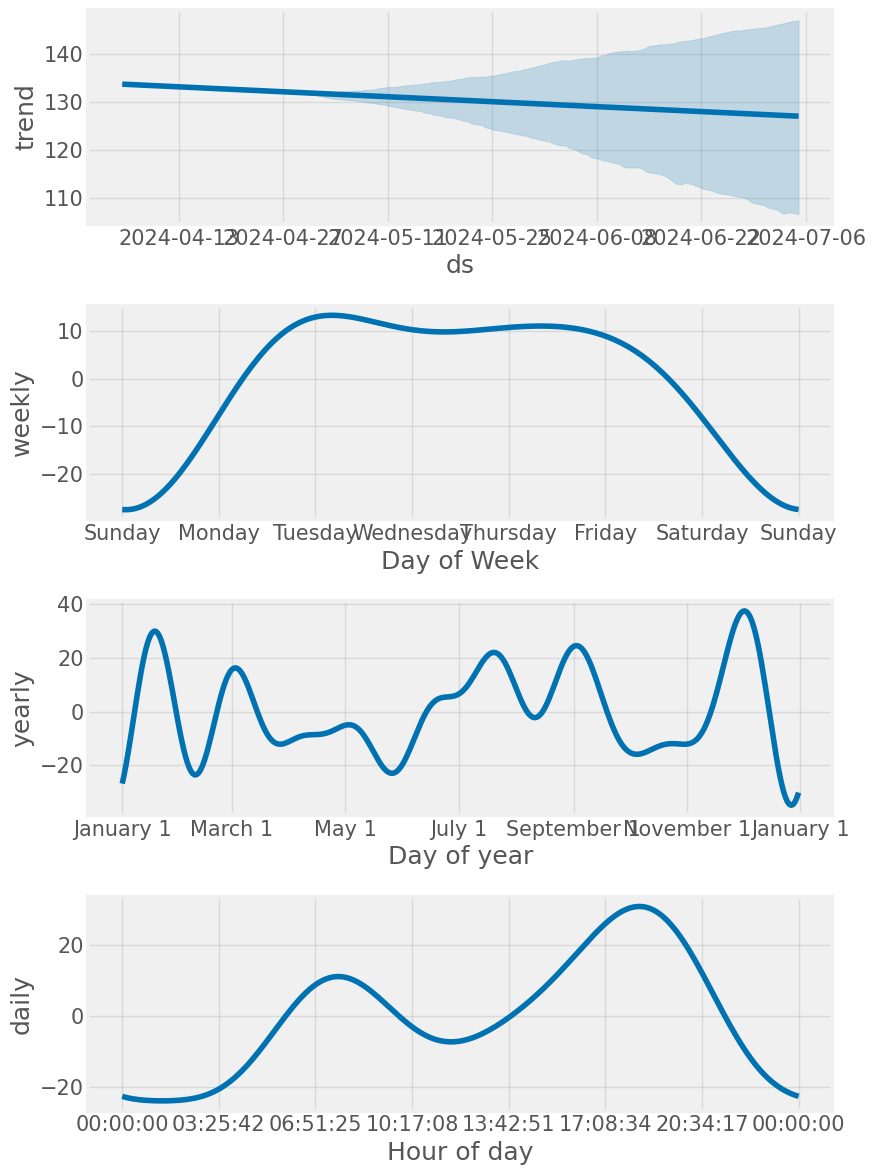

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(CO2_test_forecast, ax=ax)
ax.set_title('Forecasting using test data only')
plt.show()

# test data components
fig2 = model.plot_components(CO2_test_forecast)
fig2.show()

### Predicting the last three months

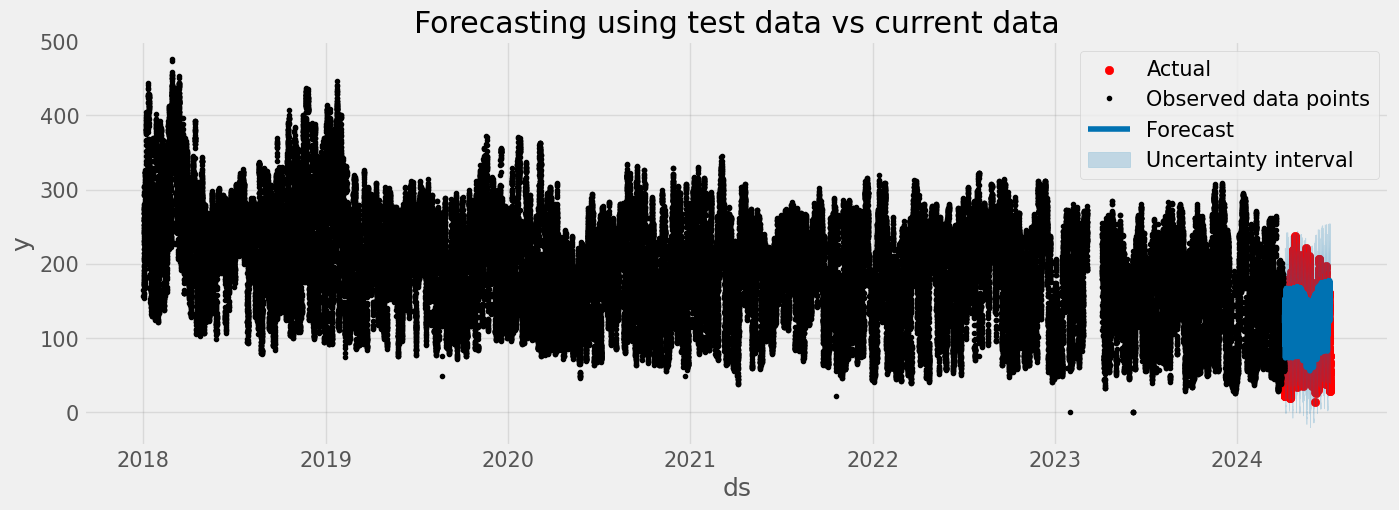

In [22]:
# Plot the forecast with the current data. This enables me to see the closest the of the result 

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(CO2_prophet_test['ds'], CO2_prophet_test['y'], color='r', label='Actual')
fig = model.plot(CO2_test_forecast, ax=ax)
ax.set_title('Forecasting using test data vs current data')
ax.legend()
plt.show()

In [23]:
# Prepare the data for Prophet to train using the ds and y as column names based on prophet specification
CO2_prophet_train = CO2.reset_index().rename(columns={'datetime': 'ds', 'actual': 'y'})

# Train the model
model = Prophet()
model.fit(CO2_prophet_train)

# The start and end dates for the last 3 months. It was consistent across the other models
start_date = '2024-05-07'

# Make a DataFrame for future dates starting from the start_date until the end of the actual data (last 3 months)
future = pd.date_range(start=start_date, end=CO2.index[-1], freq='30T').to_frame(index=False, name='ds')

# Make predictions
predictions = model.predict(future)

# Extraction of actual values from the starting date onwards
y_truth = CO2[start_date:].reset_index().rename(columns={'datetime': 'ds', 'actual': 'y'})

# Combining actual and predicted values to see side by side comparison
CO2_comparison = pd.DataFrame({
    'ds': y_truth['ds'],
    'actual': y_truth['y'],
    'predicted': predictions.set_index('ds').loc[y_truth['ds'], 'yhat'].values
})

# Display the comparison
print(CO2_comparison)

09:35:49 - cmdstanpy - INFO - Chain [1] start processing
09:37:36 - cmdstanpy - INFO - Chain [1] done processing


                      ds  actual   predicted
0    2024-05-07 00:00:00   156.0  106.250503
1    2024-05-07 00:30:00   158.0  105.469453
2    2024-05-07 01:00:00   157.0  105.181310
3    2024-05-07 01:30:00   161.0  105.177564
4    2024-05-07 02:00:00   160.0  105.407915
...                  ...     ...         ...
2798 2024-07-04 22:30:00    54.0  114.290649
2799 2024-07-04 23:00:00    53.0  110.029346
2800 2024-07-04 23:30:00    55.0  107.110866
2801 2024-07-05 00:00:00    54.0  105.319146
2802 2024-07-05 00:30:00    55.0  104.336790

[2803 rows x 3 columns]


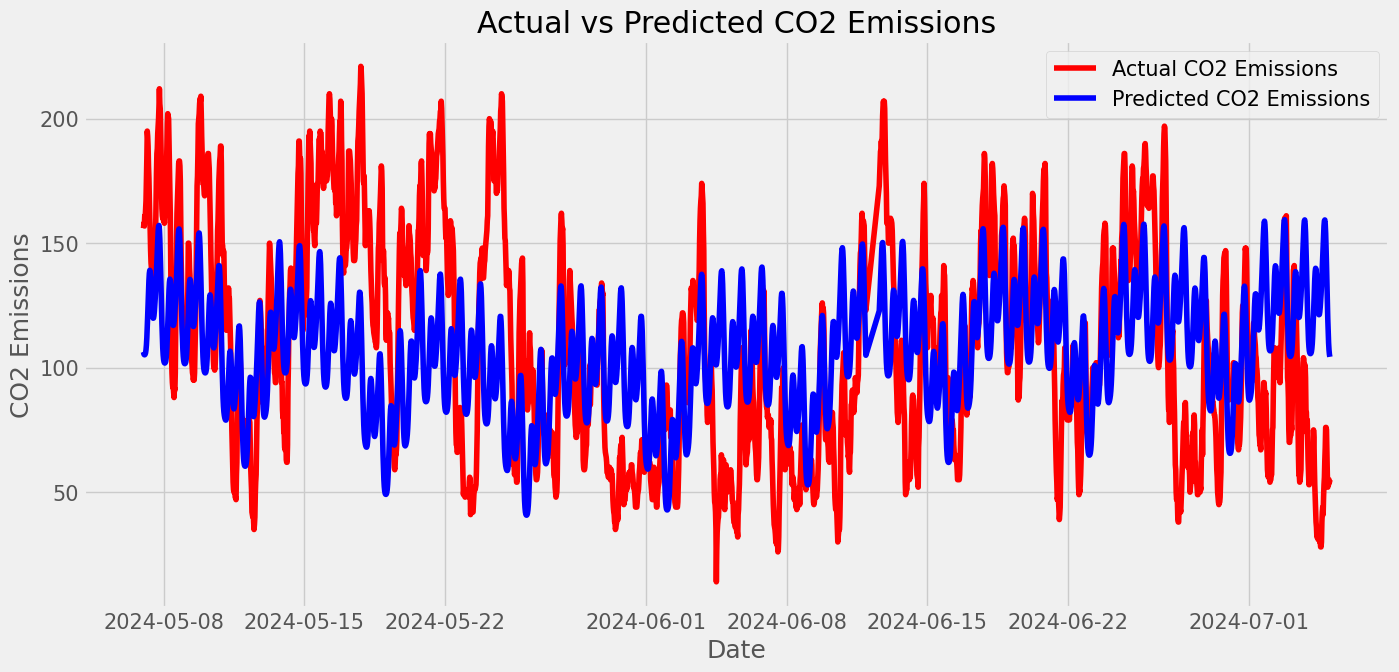

In [24]:
#Plotting the comparison
plt.figure(figsize=(15, 7))
plt.plot(CO2_comparison['ds'], CO2_comparison['actual'], label='Actual CO2 Emissions', color='r')
plt.plot(CO2_comparison['ds'], CO2_comparison['predicted'], label='Predicted CO2 Emissions', color='b')
plt.xlabel('Date')
plt.ylabel('CO2 Emissions')
plt.title('Actual vs Predicted CO2 Emissions')
plt.legend()
plt.show()

In [25]:
# MSE calculation 
mae = mean_absolute_error(CO2_comparison['actual'], CO2_comparison['predicted'])
# RMSE calculation
mse = mean_squared_error(CO2_comparison['actual'], CO2_comparison['predicted'])
# MAE calculation
rmse = np.sqrt(mse)
# r2 calculation
r2 = r2_score(CO2_comparison['actual'], CO2_comparison['predicted'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 34.30795274994899
Mean Squared Error (MSE): 1786.0308350721145
Root Mean Squared Error (RMSE): 42.26145803296562
R-squared (R2): 0.1052219814585168


In [26]:
# Get the last observed value in the training data before the start date
last_observed_value = CO2.loc[:start_date, 'actual'].iloc[-1]

# Creates the naive forecast baseline (repeating the last observed value)
baseline_pred = [last_observed_value] * len(CO2_comparison)

# Calculate baseline metrics
baseline_mae = mean_absolute_error(CO2_comparison['actual'], baseline_pred)
baseline_mse = mean_squared_error(CO2_comparison['actual'], baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(CO2_comparison['actual'], baseline_pred)

# Print baseline metrics and compare with the Prophet model
print(f"1. Baseline MAE (Naive Forecast): {baseline_mae:.4f}")
print(f"1. Mean Absolute Error (MAE): {mae}")

print(f"2. Baseline MSE (Naive Forecast): {baseline_mse:.4f}")
print(f"2. Mean Squared Error (MSE): {mse}")

print(f"3. Baseline R-squared (Naive Forecast): {baseline_r2:.4f}")
print(f"3. R-squared (R2): {r2}")

print(f"4. Baseline RMSE (Naive Forecast): {baseline_rmse:.4f}")
print(f"4. Root Mean Squared Error (RMSE): {rmse}")


1. Baseline MAE (Naive Forecast): 58.7710
1. Mean Absolute Error (MAE): 34.30795274994899
2. Baseline MSE (Naive Forecast): 4762.7902
2. Mean Squared Error (MSE): 1786.0308350721145
3. Baseline R-squared (Naive Forecast): -1.3861
3. R-squared (R2): 0.1052219814585168
4. Baseline RMSE (Naive Forecast): 69.0130
4. Root Mean Squared Error (RMSE): 42.26145803296562


# The END